In [1]:
import torch

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import transforms
from torch import nn, optim
import matplotlib.pyplot as plt
import requests
from PIL import Image 
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchmetrics.functional as metrics
from sklearn.preprocessing import LabelEncoder
from io import BytesIO

In [2]:
movieDF = pd.read_csv('data/movie_data.csv')
movieDF.head(2)

FileNotFoundError: [Errno 2] No such file or directory: 'data/movie_data.csv'

In [3]:
# 데이터 확인 -> 장르와 포스터 none값인 행 삭제
movieDF.info()

NameError: name 'movieDF' is not defined

In [354]:
movieDF = movieDF.dropna(subset=['포스터', '장르'])

In [355]:
# 데이터프레임에서 이미지 URL과 장르를 추출
image_urls = movieDF['포스터']
genres = movieDF['장르']

In [356]:
# 결측치 제거 확인
image_urls.isna().sum(), genres.isna().sum()

(0, 0)

### Comedy, Horror, Action, Animation, Romance

In [357]:
# 장르 확인
glist = set()
for genre in genres:
    if isinstance(genre, str):
        genre_list = genre.split(',')
        for g in genre_list:
            glist.add(g.strip())
    else:
        glist.add(genre)  # 문자열이 아닌 다른 형식의 데이터는 그대로 집합에 추가
glist

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'Thrillerp',
 'War',
 'Western'}

In [358]:
# Animation > SF > Horror > Romance > Action > Comedy&Drama 

for i in genres.index:
    if 'Animation' in genres[i]:
        genres[i] = 'Animation'
    elif 'Science Fiction' in genres[i]:
        genres[i] = 'SF'
    elif 'Horror' in genres[i] or 'Thriller' in genres[i]:
        genres[i] = 'Horror'
    elif 'Romance' in genres[i] or 'Family' in genres[i]:
        genres[i] = 'Romance'
    elif 'Action' in genres[i] or 'War' in genres[i] or 'Western' in genres[i]:
        genres[i] = 'Action'
    else:  
        genres[i] = 'Comedy&Drama'


C:\Users\mybae\AppData\Local\Temp\ipykernel_2236\3820454265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres[i] = 'Animation'
C:\Users\mybae\AppData\Local\Temp\ipykernel_2236\3820454265.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres[i] = 'SF'
C:\Users\mybae\AppData\Local\Temp\ipykernel_2236\3820454265.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genres[i] = 'SF'
C:\Users\mybae\AppData\Local\Temp\ipykernel_2

In [359]:
# 유니크한 장르 확인 -> 제대로 분류 완료 -> 각 라벨의 분포 시각화
genres.unique()

array(['SF', 'Animation', 'Horror', 'Action', 'Romance', 'Comedy&Drama'],
      dtype=object)

In [360]:
genreImgDF = pd.concat([image_urls, genres], axis=1)
genreImgDF.head(15)

,포스터,장르
0,https://media.themoviedb.org/t/p/w300_and_h450...,SF
1,https://media.themoviedb.org/t/p/w300_and_h450...,Animation
2,https://media.themoviedb.org/t/p/w300_and_h450...,SF
3,https://media.themoviedb.org/t/p/w300_and_h450...,SF
4,https://media.themoviedb.org/t/p/w300_and_h450...,Horror


In [361]:
genreImgDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9681 entries, 0 to 9721
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   포스터     9681 non-null   object
 1   장르      9681 non-null   object
dtypes: object(2)
memory usage: 484.9+ KB


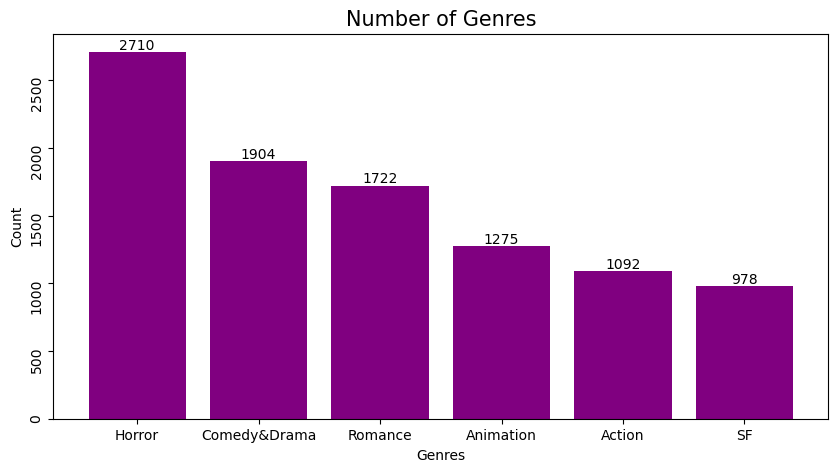

In [362]:
plt.figure(figsize=(10, 5))
plt.bar(genreImgDF['장르'].value_counts().index, genreImgDF['장르'].value_counts(), color='purple')  # bar() 함수 사용

# 각 막대 위에 텍스트 추가
for i, count in enumerate(genreImgDF['장르'].value_counts()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.yticks(rotation=90)  # x축 눈금 라벨 회전
plt.title('Number of Genres', size = 15)
plt.ylabel('Count')
plt.xlabel('Genres')
plt.show()

In [363]:
# 이미지 저장 폴더 생성
for genre in genres.unique():
    os.makedirs(os.path.join('data', genre), exist_ok=True)

# 이미지를 각 장르의 폴더에 저장
for idx, (image_url, genre) in enumerate(zip(image_urls, genres)):
    response = requests.get(image_url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        file_path = os.path.join('data', genre, f"img_{idx}.jpg")
        image.save(file_path)
        print(f"이미지 저장: {file_path}")
    else:
        print(f"이미지 다운로드 실패: {image_url}")

In [364]:
# 간단한 전처리
preprocessing = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
    ]) # 각 이미지 사이즈 (300, 450) # 사이즈 모두 동일

In [365]:
# 이미지가 저장된 폴더 경로
genre_folder = "data"

# 이미지와 라벨(폴더명)을 쌍으로 저장할 리스트
images = []
labels = []

# 각 폴더(장르)별로 이미지를 불러와서 리스트에 저장
for genre in os.listdir(genre_folder):
    genre_path = os.path.join(genre_folder, genre)
    if os.path.isdir(genre_path):
        for file_name in os.listdir(genre_path):
            img_path = os.path.join(genre_path, file_name)  # 이미지 파일 경로
            # 이미지 불러오기
            try:
                image = Image.open(img_path)
                image = preprocessing(image)
                if image.shape[0] == 3:  # 채널이 3인 경우에만 저장
                    images.append(image)
                    labels.append(genre)
            except Exception as e:
                print(f"이미지 불러오기 실패: {img_path}, Error: {e}")


In [366]:
from collections import Counter

genre_counts = Counter(labels)
genre_counts

Counter({'Action': 8728,
         'Animation': 10200,
         'Comedy&Drama': 7552,
         'Horror': 6374,
         'Romance': 6880,
         'SF': 7888})

In [367]:
genre_counts

Counter({'Action': 8728,
         'Animation': 10200,
         'Comedy&Drama': 7552,
         'Horror': 6374,
         'Romance': 6880,
         'SF': 7888})

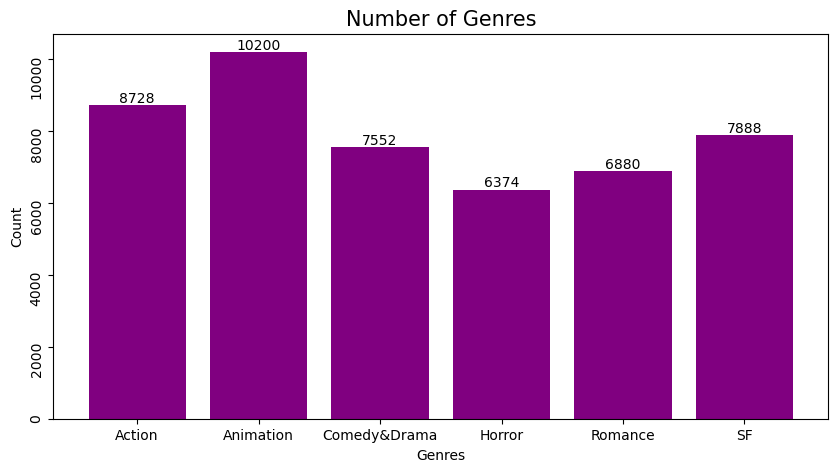

In [368]:
# 라벨별 갯수 세기
genre_counts = Counter(labels)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.bar(genre_counts.keys(), genre_counts.values(), color='purple')  # bar() 함수 사용

# 각 막대 위에 텍스트 추가
for i, count in enumerate(genre_counts.values()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.yticks(rotation=90)  # x축 눈금 라벨 회전
plt.title('Number of Genres', size = 15)
plt.ylabel('Count')
plt.xlabel('Genres')
plt.show()

In [369]:
# 라벨 인코딩
# 디코딩 : encoder.inverse_transform(encoded_labels)
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)

In [370]:
for i in labels:
    i = float(i)

In [371]:
xtrain, xval, ytrain, yval = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [372]:
# 이미지 shape 확인
xtrain[0].shape, xtrain[0].ndim

(torch.Size([3, 32, 32]), 3)

In [373]:
class imgDataSet(Dataset):
    def __init__(self, xdata, ydata):
        # 텐서화
        self.image = xdata
        self.label = torch.LongTensor(ydata)

    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, idx):
        image, label = self.image[idx], self.label[idx]
        return image, label

In [374]:
trainDS = imgDataSet(xtrain,ytrain)
validDS = imgDataSet(xval, yval)

In [375]:
# 높이, 너비를 기준으로 채널의 평균과 표준편차 구하기
meanRGB = [np.mean(f.numpy(), axis=(1,2)) for f,l in trainDS]
stdRGB = [np.std(f.numpy(), axis=(1,2)) for f,l in trainDS]

In [376]:
meanR = np.mean([i[0] for i in meanRGB])
meanG = np.mean([i[1] for i in meanRGB])
meanB = np.mean([i[2] for i in meanRGB])

stdR = np.std([i[0] for i in stdRGB])
stdG = np.std([i[1] for i in stdRGB])
stdB = np.std([i[2] for i in stdRGB])

In [377]:
stdR,stdG,stdB

(0.06612781, 0.0661105, 0.0765386)

In [378]:
normalize = transforms.Normalize(mean=[meanR, meanG, meanB], std=[stdR, stdG, stdB])

# 데이터셋 내의 모든 이미지에 대해 정규화 진행
trainDS = [(normalize(img), label) for img, label in trainDS]
validDS = [(normalize(img), label) for img, label in validDS]

In [379]:
from collections import Counter # 요소의 개수 반환 : dict

# 클래스별 비율 계산
train_class = {label: count / len(trainDS) for label, count in Counter([label for _, label in trainDS]).items()}
valid_class = {label: count / len(validDS) for label, count in Counter([label for _, label in validDS]).items()}


train_class, valid_class 

({tensor(1): 2.6248785993647795e-05,
  tensor(1): 2.6248785993647795e-05,
  tensor(0): 2.6248785993647795e-05,
  tensor(2): 2.6248785993647795e-05,
  tensor(4): 2.6248785993647795e-05,
  tensor(5): 2.6248785993647795e-05,
  tensor(3): 2.6248785993647795e-05,
  tensor(0): 2.6248785993647795e-05,
  tensor(2): 2.6248785993647795e-05,
  tensor(4): 2.6248785993647795e-05,
  tensor(1): 2.6248785993647795e-05,
  tensor(2): 2.6248785993647795e-05,
  tensor(4): 2.6248785993647795e-05,
  tensor(1): 2.6248785993647795e-05,
  tensor(3): 2.6248785993647795e-05,
  tensor(3): 2.6248785993647795e-05,
  tensor(3): 2.6248785993647795e-05,
  tensor(5): 2.6248785993647795e-05,
  tensor(1): 2.6248785993647795e-05,
  tensor(2): 2.6248785993647795e-05,
  tensor(3): 2.6248785993647795e-05,
  tensor(4): 2.6248785993647795e-05,
  tensor(4): 2.6248785993647795e-05,
  tensor(4): 2.6248785993647795e-05,
  tensor(0): 2.6248785993647795e-05,
  tensor(5): 2.6248785993647795e-05,
  tensor(0): 2.6248785993647795e-05,
 

In [380]:
SAMPLER = WeightedRandomSampler(weights=[train_class[label] for _,label in trainDS], num_samples=len(trainDS), replacement=True)

BATCH = 32
# DataLoader 생성
trainDL = DataLoader(trainDS, batch_size=BATCH, sampler=SAMPLER)
validDL = DataLoader(validDS, batch_size=BATCH)

In [381]:
for images, labels in trainDL:
    print("Batch Shape:", images.shape)
    break

Batch Shape: torch.Size([32, 3, 32, 32])


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # 배치 정규화 층 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # 배치 정규화 층 추가

        self.fc1 = nn.Linear(32 * 75 * 75, 32) 
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 6)  # 클래스의 수에 맞게 수정
    
        nn.init.kaiming_uniform_(self.conv1.weight)
        nn.init.kaiming_uniform_(self.conv2.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # 배치 정규화 적용
        x = F.relu(x)
        x = self.pool(x)  # 풀링 적용

        x = self.conv2(x)
        x = self.bn2(x)  # 배치 정규화 적용
        x = F.relu(x) 
        x = self.pool(x)

        x = x.view(-1, 32 * 8 * 8) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

In [382]:
class CNN32(nn.Module):
    def __init__(self):
        super(CNN32, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)  # 배치 정규화 층 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)  # 배치 정규화 층 추가

        self.fc1 = nn.Linear(32 * 8 * 8, 32) 
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 6)  # 클래스의 수에 맞게 수정
    
        nn.init.kaiming_uniform_(self.conv1.weight)
        nn.init.kaiming_uniform_(self.conv2.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # 배치 정규화 적용
        x = F.relu(x)
        x = self.pool(x)  # 풀링 적용

        x = self.conv2(x)
        x = self.bn2(x)  # 배치 정규화 적용
        x = F.relu(x) 
        x = self.pool(x)

        x = x.view(-1, 32 * 8 * 8) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x


In [383]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepCNN32(nn.Module):
    def __init__(self):
        super(DeepCNN32, self).__init__()

        # 첫 번째 합성곱 층
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 두 번째 합성곱 층
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # 세 번째 합성곱 층
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        # 네 번째 합성곱 층
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        # 완전 연결층
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 6)  # 클래스의 수에 맞게 수정

    def forward(self, x):
        # 첫 번째 합성곱 층
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # 두 번째 합성곱 층
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # 세 번째 합성곱 층
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        # 네 번째 합성곱 층
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.view(-1, 128 * 4 * 4)

        # 완전 연결층
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

In [384]:
class CNN64(nn.Module):
    def __init__(self):
        super(CNN64, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화 층 추가
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # 배치 정규화 층 추가

        self.fc1 = nn.Linear(64 * 16 * 16, 32) 
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 6)  # 클래스의 수에 맞게 수정
    
        nn.init.kaiming_uniform_(self.conv1.weight)
        nn.init.kaiming_uniform_(self.conv2.weight)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)  # 배치 정규화 적용
        x = F.relu(x)
        x = self.pool(x)  # 풀링 적용

        x = self.conv2(x)
        x = self.bn2(x)  # 배치 정규화 적용
        x = F.relu(x) 
        x = self.pool(x)

        x = x.view(-1, 64 * 16 * 16) 
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

In [385]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

EPOCHS = 100

model = CNN32()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr = 0.001)

SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode = 'min', patience = 10)

LF = nn.CrossEntropyLoss()

In [386]:
def training(dl):
    model.train()
    lossList = []
    accList = []
    for (img,label) in dl:
        img = img
        label = label
        OPTIMIZER.zero_grad()
        output = model(img)
        loss = LF(output, label)
        loss.backward()
        OPTIMIZER.step()
        _, preds = torch.max(output, 1)
        f1 = metrics.f1_score(output, label, task = 'multiclass', num_classes=genreImgDF['장르'].nunique(), average='macro')
        lossList.append(loss.item())
        accList.append(f1)
    train_loss = sum(lossList)/len(lossList)
    train_acc = sum(accList)/len(accList)
    return train_loss,train_acc

In [387]:
def testing(dl):
    model.eval()
    lossList = []
    accList = []
    
    with torch.no_grad():
        for (img,label) in dl:
            img = img
            label = label
            output = model(img)
            loss = LF(output, label)
            lossList.append(loss.item())
            _, preds = torch.max(output, 1)  
            f1 = metrics.f1_score(output, label, task = 'multiclass', num_classes=genreImgDF['장르'].nunique(), average='macro')
            accList.append(f1)
    valid_loss = sum(lossList)/len(lossList)
    valid_acc = sum(accList)/len(accList)
    return valid_loss, valid_acc

In [388]:
train_report = [[],[]]
val_report = [[],[]]
minLoss = 10

for epoch in range(1,EPOCHS+1):
    train_loss, train_acc = training(trainDL)
    valid_loss, valid_acc = testing(validDL)
    train_report[0].append(train_loss)
    train_report[1].append(train_acc)
    val_report[0].append(valid_loss)
    val_report[1].append(valid_acc)
    print(f'[EPOCH: {epoch}]')
    print(f"Train Loss : {train_loss:.4f}, \tTrain Accuracy : {train_acc:.2f}  ")
    print(f"Test Loss : {valid_loss:.4f}, \t Test Accuracy : {valid_acc:.2f}  ")
    # SCHEDULER.step(valid_loss)
    if valid_loss < minLoss:
        minLoss = valid_loss
        torch.save(model, 'model/movie_genre32_batch256_16.pt')
    # if SCHEDULER.num_bad_epochs >= SCHEDULER.patience:
    #     print(f'조기 종료 at epoch {epoch}')
    #     break

KeyboardInterrupt: 

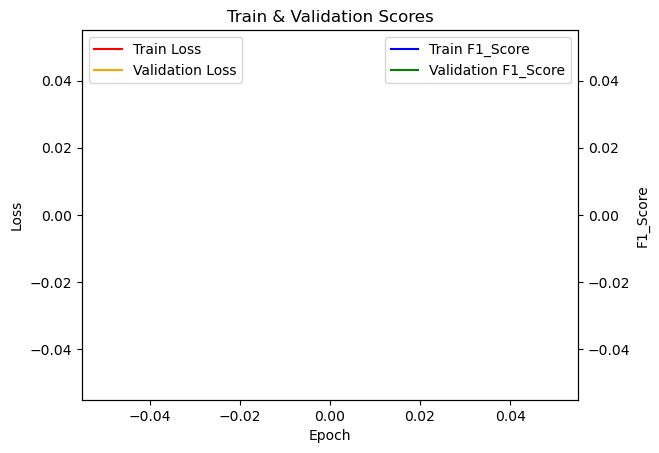

In [389]:
fig, ax1 = plt.subplots()  


ax1.plot(train_report[0], label='Train Loss', color='red')
ax1.plot(val_report[0], label='Validation Loss', color='orange')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(train_report[1], label='Train F1_Score', color='blue')
ax2.plot(val_report[1], label='Validation F1_Score', color='green')
ax2.set_ylabel('F1_Score')
ax2.set_xlabel('Epoch')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.xlabel('Epoch')  
plt.title('Train & Validation Scores')
plt.show()

In [ ]:
model = CNN()

model = torch.load('model/movie_genre2.pt')

In [ ]:
preprocessing = transforms.Compose([
    transforms.Resize((16,16)),
    transforms.Normalize(mean=(0.38588074, 0.3442984, 0.32389283), std=(0.06522466, 0.06430584, 0.073496684)),
    transforms.ToTensor()
])

In [ ]:
# html img에 데이터 넣었을때 결과 반환 함수
def predict(img):
    img = preprocessing(img)
    img = img.unsqueeze(0)
    img = img.to(DEVICE)
    with torch.no_grad():
        output = model(img)
        _, preds = torch.max(output, 1)
        pred = genreImgDF['장르'].unique()[preds.item()]
        